# 141B Final Project: Vaccine Hesitancy in the United States
## by Antonio Pelayo, Gianni Spiga, and Sharon Vien

In this notebook, we explore data provided by the CDC in regards to the hesistancy of adults in the United States in hopes to find any patterns or trends that might help better prepare for more efficient vaccine rollout on a nationwide and statewide scale in the future.

## Grading Criteria 
1. Project organization, writeup readability, and overall conclusions
2. Code quality, readability, and efficiency 
3. Data Munging
4. Data Visualizations
5. Data Extraction

## Table of Contents
* [Data Extraction](#data-extraction)
* [Variable Descriptions](#variable-description)
* [Data Munging and Cleaning](#data-munging)
* [Data Visualization](#data-visualization)
* [Conclusions](#conclusions)

In [1]:
# Libraries
import datetime
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Other data used in the analysis
county_deaths_df = pd.read_csv('data/cdc-deaths-by-county-and-race.csv')
state_abbreviations_df = pd.read_csv('data/state-abbreviations.csv')
state_parties_df = pd.read_csv('data/state-political-parties.csv')
state_populations_df = pd.read_csv('data/census-2020-county-population-totals.csv')

<a id="data-extraction"></a>
### Extracting the Data

In [2]:
# Request hesitancy data
hesitancy_endpoint = 'https://data.cdc.gov/resource/q9mh-h2tw.json?$limit=4000'

r = requests.get(hesitancy_endpoint)
hesitancy_df = pd.DataFrame(r.json())
hesitancy_df.head()

,fips_code,county_name,state,estimated_hesitant,estimated_hesitant_or_unsure,estimated_strongly_hesitant,social_vulnerability_index,svi_category,ability_to_handle_a_covid,cvac_category,...,percent_non_hispanic_asian,percent_non_hispanic_black,percent_non_hispanic_native,percent_non_hispanic_white,geographical_point,state_code,county_boundary,state_boundary,:@computed_region_hjsp_umg2,:@computed_region_skr5_azej
0,1123,"Tallapoosa County, Alabama",ALABAMA,0.1806,0.24,0.1383,0.89,Very High Vulnerability,0.64,High Concern,...,0.0036,0.2697,0,0.6887,"{'type': 'Point', 'coordinates': [-86.844516, ...",AL,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...","{'type': 'MultiPolygon', 'coordinates': [[[[-8...",29,94
1,1121,"Talladega County, Alabama",ALABAMA,0.1783,0.235,0.1368,0.87,Very High Vulnerability,0.84,Very High Concern,...,0.0061,0.3237,0.0003,0.6263,"{'type': 'Point', 'coordinates': [-86.844516, ...",AL,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...","{'type': 'MultiPolygon', 'coordinates': [[[[-8...",29,94
2,1131,"Wilcox County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.93,Very High Vulnerability,0.94,Very High Concern,...,0.0003,0.6938,0,0.2684,"{'type': 'Point', 'coordinates': [-86.844516, ...",AL,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...","{'type': 'MultiPolygon', 'coordinates': [[[[-8...",29,94
3,1129,"Washington County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.73,High Vulnerability,0.82,Very High Concern,...,0.0025,0.2354,0,0.6495,"{'type': 'Point', 'coordinates': [-86.844516, ...",AL,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...","{'type': 'MultiPolygon', 'coordinates': [[[[-8...",29,94
4,1133,"Winston County, Alabama",ALABAMA,0.1805,0.2313,0.1379,0.7,High Vulnerability,0.8,High Concern,...,0.0016,0.0073,0.0005,0.937,"{'type': 'Point', 'coordinates': [-86.844516, ...",AL,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...","{'type': 'MultiPolygon', 'coordinates': [[[[-8...",29,94


In [3]:
# Request vaccination data
cdc_completed_vaccinations_endpoint = 'https://data.cdc.gov/resource/8xkx-amqh.json?$limit=5000'
r = requests.get(cdc_completed_vaccinations_endpoint)
county_vaccination_counts_df = pd.DataFrame(r.json())
# county_vaccination_counts_df.head()
county_vaccination_counts_df = county_vaccination_counts_df.filter(
    [
        'date',
        'recip_state',
        'series_complete_yes'
    ]
)

# Filter by today's date in format YYYY-MM-DD
today = datetime.datetime(2021, 12, 9).strftime('%Y-%m-%d')
today = today + 'T00:00:00.000'
county_vaccination_counts_df = county_vaccination_counts_df[
    county_vaccination_counts_df['date'] == today
]

# Turn completed vaccination counts into integers
county_vaccination_counts_df['series_complete_yes'] = county_vaccination_counts_df['series_complete_yes'].astype(int)
county_vaccination_counts_df['State Abbreviation'] = county_vaccination_counts_df['recip_state'].str.upper()

# Group counts by state
state_vaccinations_df = county_vaccination_counts_df.groupby('State Abbreviation').sum()
state_vaccinations_df.head()

,series_complete_yes
State Abbreviation,
AK,404199
AL,2288180
AR,1510981
AS,31594
AZ,4043529


<a id="variable-description"></a>
### Addressing and Understanding our Variables

In [4]:
hesitancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   fips_code                      3142 non-null   object
 1   county_name                    3142 non-null   object
 2   state                          3142 non-null   object
 3   estimated_hesitant             3142 non-null   object
 4   estimated_hesitant_or_unsure   3142 non-null   object
 5   estimated_strongly_hesitant    3142 non-null   object
 6   social_vulnerability_index     3141 non-null   object
 7   svi_category                   3141 non-null   object
 8   ability_to_handle_a_covid      3142 non-null   object
 9   cvac_category                  3142 non-null   object
 10  percent_adults_fully           2864 non-null   object
 11  percent_hispanic               3142 non-null   object
 12  percent_non_hispanic_american  3142 non-null   object
 13  per

#### Variable Definitions
1. fips_code = numbers that uniquely identify geographic areas  
2. county_name = name of county  
3. state = name of state  
4. estimated_hesitant = percent of population that indicated they would "probably not" or "definitely not" receive a COVID-19 vaccine when available  
5. estimated_hesitant_or_unsure = percent of population that indicated they would "probably not" or "unsure" or "definitely not" receive a COVID-19 vaccine when available  
6. estimated_strongly_hesitant = percent of population that indicated they would "definitely not" receive a COVID-19 vaccine when available  
7. social_vulnerability_index = the extent to which a community is socially vulnerable to disaster. The factors considered in developing the SVI include economic data as well as data regarding education, family characteristics, housing language ability, ethnicity, and vehicle access.   
8. svi_category = low, moderate, high, very high vulnerability   
9. ability_to_handle_a_covid = ability to handle Covid-19 outbreak in percent  
10. cvac_category = level of concern for vaccine rollout   
11. percent_adults_fully = percent of adults fully vaccinated  
12. percent_hispanic = percent of hispanic adults fully vaccinated   
13. percent_non_hispanic_american = percent of non hispanic american adults fully vaccinated    
14. percent_non_hispanic_asian = percent of non hispanic asian adults fully vaccinated  
15. percent_non_hispanic_black = percent of non hispanic black adults fully vaccinated  
16. percent_non_hispanic_native = percent of non hispanic native adults fully vaccinated  
17. percent_non_hispanic_white = percent of non hispanic white adults fully vaccinated  
18. geographical point = where the county lies  
19. state_code = code of the state  
20. county_boundary = coordinates of boundary  
21. state_boundary = coordinate of state boundary

<a id="data-munging"></a>
### Data Munging and Cleaning

#### Hesitancy of vaccines by political parties in the US

In [5]:
# Filter hesitancy data
hesitancy_by_state_df = hesitancy_df.filter(
    [
        'state', 
        'estimated_hesitant',
        'estimated_hesitant_or_unsure',
        'estimated_strongly_hesitant'
    ]
)

# Set values to numeric
hesitancy_by_state_df['estimated_hesitant'] = hesitancy_by_state_df['estimated_hesitant'].astype(float)
hesitancy_by_state_df['estimated_hesitant_or_unsure'] = hesitancy_by_state_df['estimated_hesitant_or_unsure'].astype(float)
hesitancy_by_state_df['estimated_strongly_hesitant'] = hesitancy_by_state_df['estimated_strongly_hesitant'].astype(float)

# Calculate non-hesitant proportion
hesitancy_by_state_df['estimated_not_hesitant'] = 1 - (
    hesitancy_by_state_df['estimated_hesitant'] + hesitancy_by_state_df['estimated_hesitant_or_unsure'] + hesitancy_by_state_df['estimated_strongly_hesitant']
)

# Gropu by state
hesitancy_by_state_df = hesitancy_by_state_df.groupby('state').mean()

# Attatch state Governer's party affiliaition
state_parties_df['State'] = state_parties_df['Location'].apply(
    lambda x: x.upper() # Uppercase all state names
)
state_parties_df.drop(columns=['Location'], inplace=True) 
state_parties_df.set_index('State', inplace=True)

hesitancy_by_state_df = hesitancy_by_state_df.merge(state_parties_df, left_index=True, right_index=True)
hesitancy_by_state_df.head()


,estimated_hesitant,estimated_hesitant_or_unsure,estimated_strongly_hesitant,estimated_not_hesitant,Governor Political Affiliation
state,,,,,
ALABAMA,0.173507,0.231512,0.132409,0.462572,Republican
ALASKA,0.217386,0.264245,0.156907,0.361462,Republican
ARIZONA,0.159240,0.242547,0.121353,0.476860,Republican
ARKANSAS,0.212123,0.261232,0.139901,0.386744,Republican
CALIFORNIA,0.072274,0.111041,0.035807,0.780878,Democrat


#### Proportions of COVID-19 deaths vs proportion of state population vaccinated

In [6]:
# Filter for states with at least 100 completed vaccinations
state_vaccinations_df = state_vaccinations_df[
    state_vaccinations_df['series_complete_yes'] >= 100
]

# Join with population data for each state
state_populations_df = state_populations_df[
    state_populations_df['STNAME'] == state_populations_df['CTYNAME']
]

# Filter columns 
state_populations_df['State Name'] = state_populations_df['STNAME'].str.upper()
state_populations_df = state_populations_df.filter(
    ['State Name', 'POPESTIMATE2020']
)

# Sum county populations
state_populations_df = state_populations_df.groupby('State Name').sum()   

# Merge vaccination counts with population data on state abbreviations
state_populations_df = state_populations_df.join(
    state_abbreviations_df.set_index('State Name'), 
    on='State Name'
)

# Join
state_vaccinations_df = state_vaccinations_df.join(
    state_populations_df.reset_index().set_index('State Abbreviation'),
).dropna(how='any')

# # Calculate vaccinated proportion
state_vaccinations_df['Vaccine Proportion'] = state_vaccinations_df['series_complete_yes'] / state_vaccinations_df['POPESTIMATE2020']

# Calculate proportion of COVID-19 deaths
county_deaths_df = county_deaths_df.iloc[::3]

state_deaths_df = county_deaths_df.groupby('State').sum()
state_deaths_df = state_deaths_df.filter(['Total deaths', 'COVID-19 Deaths'])

state_deaths_df['COVID-19 Death Proportion'] = state_deaths_df['COVID-19 Deaths'] / state_deaths_df['Total deaths']
state_deaths_df.index.rename('State Abbreviation', inplace=True)

state_vaccinations_df = state_vaccinations_df.join(
    state_deaths_df
)

state_vaccinations_df = state_vaccinations_df.filter(
    [
        'State Name', 
        'series_complete_yes', 
        'POPESTIMATE2020', 
        'Vaccine Proportion', 
        'COVID-19 Deaths', 
        'Total deaths',
        'COVID-19 Death Proportion'
    ]
)
state_vaccinations_df.head()

,State Name,series_complete_yes,POPESTIMATE2020,Vaccine Proportion,COVID-19 Deaths,Total deaths,COVID-19 Death Proportion
State Abbreviation,,,,,,,
AK,ALASKA,404199,731158.0,0.552820,764,7025,0.108754
AL,ALABAMA,2288180,4921532.0,0.464932,14461,104758,0.138042
AR,ARKANSAS,1510981,3030522.0,0.498588,7338,51752,0.141792
AZ,ARIZONA,4043529,7421401.0,0.544847,20202,145717,0.138639
CA,CALIFORNIA,25429366,39368078.0,0.645939,77073,600256,0.128400


<a id="data-visualization"></a>
### Visualizing the Data

We will explore numerous visualizations such as scatterplots, boxplots, and density graphs to better understand the data. 

#### Boxplot of hesitancy estimates by political party

array([[<AxesSubplot:title={'center':'estimated_hesitant'}, xlabel='Governor Political Affiliation'>,
        <AxesSubplot:title={'center':'estimated_hesitant_or_unsure'}, xlabel='Governor Political Affiliation'>],
       [<AxesSubplot:title={'center':'estimated_strongly_hesitant'}, xlabel='Governor Political Affiliation'>,
        <AxesSubplot:title={'center':'estimated_not_hesitant'}, xlabel='Governor Political Affiliation'>]],
      dtype=object)

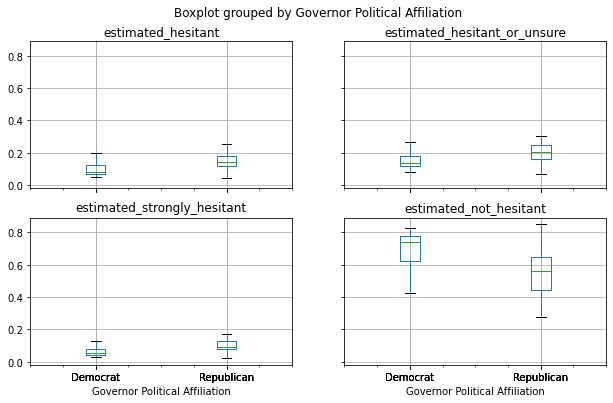

In [7]:
# Boxplot of hesitancy estimates by political party 
hesitancy_by_state_df.boxplot(
    column=[
        'estimated_hesitant', 
        'estimated_hesitant_or_unsure', 
        'estimated_strongly_hesitant',
        'estimated_not_hesitant'
    ], 
    by='Governor Political Affiliation',
    figsize=(10, 6)
)

These boxplots show that Republicans are much more likely to be hesitant towards the COVID-19 vaccine than Democrats.
In other notebooks we look into death proportions by state and political party to see if there is a difference in proportion of deaths due to COVID-19. It would make sense to see a higher proportion of COVID-19 deaths in Republican governed states due to the hesitancy and lack of vaccinations.

#### Boxplot of COVID-19 Death proportions vs Vaccine proportions by state

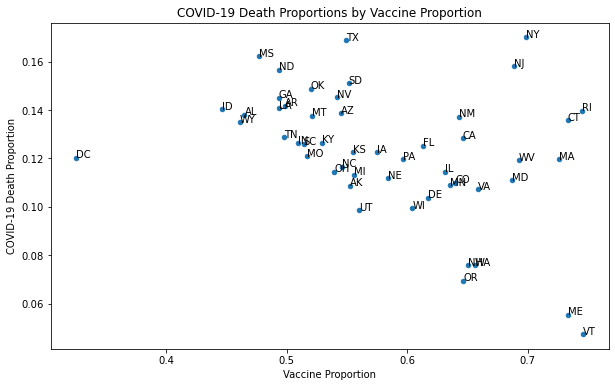

In [8]:
# Plot boxplot
state_vaccinations_df.plot(
    x='Vaccine Proportion',
    y='COVID-19 Death Proportion',
    kind='scatter',
    title='COVID-19 Death Proportions by Vaccine Proportion',
    figsize=(10, 6)
)

# Annotate points
for idx, row in state_vaccinations_df.iterrows(): 
    plt.text(row['Vaccine Proportion'], row['COVID-19 Death Proportion'], idx)

In [9]:
# Compute correlation coefficient
death_vax_correlation = state_vaccinations_df['Vaccine Proportion'].corr(state_vaccinations_df['COVID-19 Death Proportion'])
print(f'Correlation coefficient: {death_vax_correlation}')

Correlation coefficient: -0.4002944976189329


This scatter plot and negative correlation coeffifient indicates that the proportion of COVID-19 deaths decreases as the proportion of people vaccinated increases. This is a good indication on the benefits of vaccination.

Hawaii was the only state ommited from the analysis due to the lack of vaccination data. 

<a id='conclusions'></a>
### Conclusions 